In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
# List of tickers to be downloaded
# You can uncomment the set of tickers you are interested in

tickers = ['IEF', 'TLT', 'SHY', 'HYG', 'AGG', 'BND', 'EMB', 'MUB', 'PFF', 'TIP', '^GSPC', 'LQD', 'UDN', 'EURUSD=X', '^VIX', '^IRX', '^FVX', '^TNX', '^TYX']
tickers = ['IEF', 'AGG', 'BND', 'TLT', 'SHY', 'TIP',]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


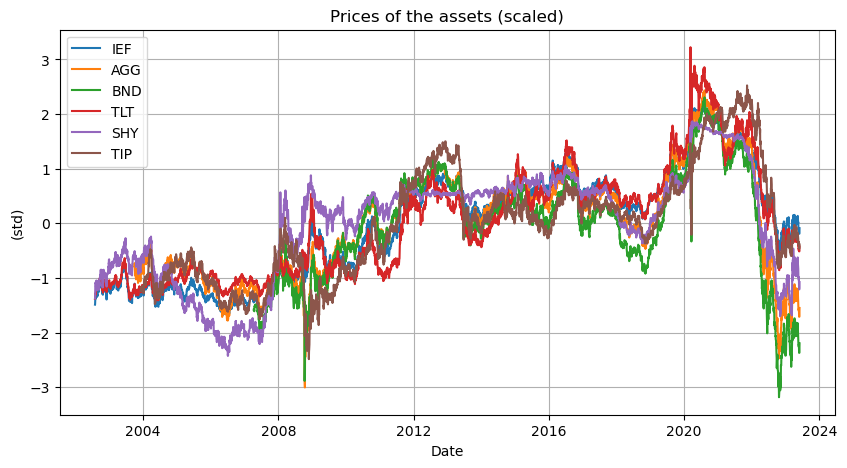

In [3]:
from basic_finance_tools import get_or_download_data, plot_df

# Specify the date range for data download
start = '2000-06-01'
end = '2023-06-01'

prices_data = get_or_download_data(tickers, start_date = start, end_date = end)
prices_data = prices_data.resample('1B').ffill()

plot_df(prices_data, title= 'Prices of the assets', unit='USD', scaled=True)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet

def compute_signal_PCA(prices: pd.DataFrame, n_principal_component: int = 1, training_size: int = 12):
    """
    Compute trading signals using Principal Component Analysis (PCA) and ElasticNet regression.

    - PCA Application: Reduces the dimensionality of price data to a specified number of principal components, 
      capturing the main variations in the data while reducing noise and complexity.
      
    - ElasticNet Modeling: Applies ElasticNet regression to the principal components. 
      ElasticNet, which combines L1 and L2 regularizations, is used to predict residuals, 
      representing the parts of the data not explained by PCA.

    - Signal Calculation: Trading signals are derived from the residuals predicted by ElasticNet regression. 
      These signals aim to capture trading opportunities by identifying deviations from what the PCA-ElasticNet model can explain.
    
    Parameters:
    - prices (pd.DataFrame): The DataFrame containing stock prices.
    - n_principal_component (int): The number of principal components for the PCA.
    - training_size (int): The window size for training the model.
    
    Returns:
    - signals (pd.DataFrame): The DataFrame containing trading signals.
    """
    
    scaler = StandardScaler()
    pca = PCA(n_components=n_principal_component) 
    en = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)

    signals = pd.DataFrame(index=prices.index, columns=prices.columns)

    for p in range(1, len(prices)//training_size):

            index_day = p * training_size

            X_train = prices.pct_change().iloc[index_day-training_size : index_day , :].ffill().fillna(0)
            X_train_scaled = scaler.fit_transform(X_train)
            X_train_pca = pca.fit_transform(X_train_scaled)
            en.fit(X=X_train_pca, y=X_train_scaled)

            X = prices.pct_change().iloc[index_day : index_day + training_size, :].ffill().fillna(0)
            X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns, index=X.index)
            X_pca = pca.transform(X_scaled)
            predicted_residual = X_scaled - en.predict(X_pca)

            signals.iloc[index_day : index_day + training_size, :] = predicted_residual.values    
    
    return signals

In [5]:
from basic_finance_tools import compute_position, compute_PNL, compute_metrics, plot_ds_hue

def show_strat_PCA(prices: pd.DataFrame, ts: int, N:int = 1) -> None:
    """
    Demonstrates a trading strategy based on moving Z-scores and visualizes the results.

    Parameters:
    - prices (pd.DataFrame): DataFrame containing asset prices.
    - wz1 (int): Window size for short-term Z-score calculation.
    - wz2 (int): Window size for long-term Z-score calculation.
    - wvt (int): Window size for volatility targeting adjustment.
    """
    tickers = prices.columns

    # Create a signal based on the difference of the prices zscore if wz1 != 0, by the difference of the prices if wz1=0
    signal = pd.DataFrame(index=prices.index, columns=tickers)
    signal = - compute_signal_PCA(prices, n_principal_component=N, training_size=ts)

    # Compute positions: if the signal is above a threshold, use it to scale the price; otherwise, position is 0
    positions = compute_position(signal, prices, threshold=1.5)

    # Compute PnL: daily profit or loss based on the price changes and previous day's positions
    pnl = compute_PNL(positions, prices)

    # Compute and display key performance metrics (Sharpe ratio, turnover, basis points, etc.)
    metrics = compute_metrics(pnl, positions)
    print(metrics)

    # Plot daily PnL against the average absolute signal strength
    plot_ds_hue(pnl['DAILY'], signal.abs().mean(axis=1), title="PNL vs Signal Hue")

{'sharpe_ratio': 0.07, 'turnover': 121.8, 'bips': 0.7, 'effective_sharpe_ratio': 0.11, 'effective_turnover': 301.2, 'effective_bips': 1.8}


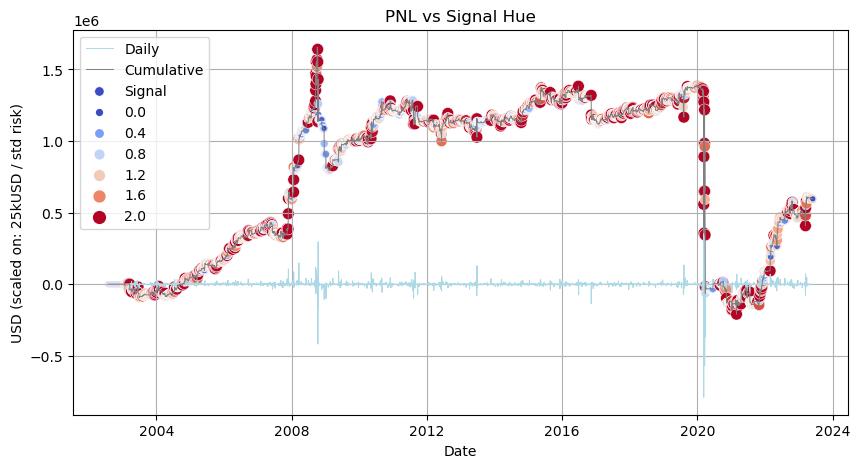

{'sharpe_ratio': 0.07, 'turnover': 122.2, 'bips': 0.7, 'effective_sharpe_ratio': 0.11, 'effective_turnover': 302.7, 'effective_bips': 1.7}


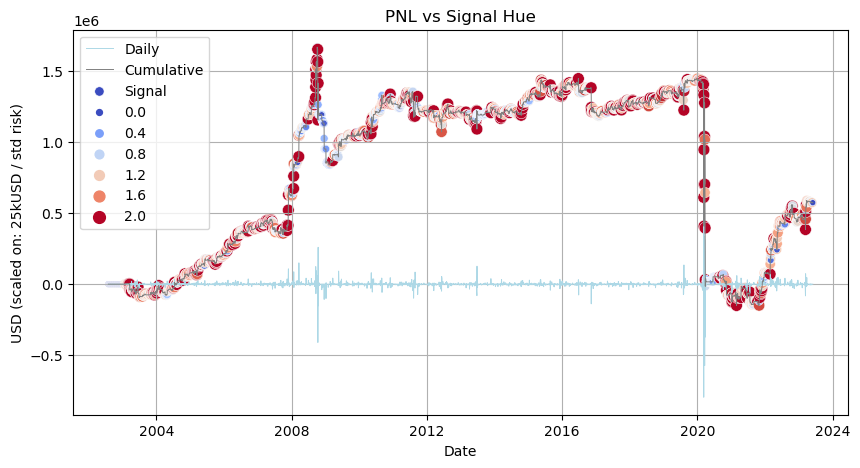

In [6]:
prices = prices_data.copy()
show_strat_PCA(prices,ts=30, N=1)
show_strat_PCA(prices,ts=30, N=3)

# 3 different trajectory of the PnL using 2 different parameters set
# NB: complete dataset start in 2008

ts [10, 25, 41, 56, 72, 87, 103, 118, 134, 150]
N [1, 2, 3]
Best Parameters: {'ts': 10, 'N': 1}
Best Result: 0.35


{'sharpe_ratio': 0.2, 'turnover': 127.8, 'bips': 1.5, 'effective_sharpe_ratio': 0.32, 'effective_turnover': 335.5, 'effective_bips': 3.9}


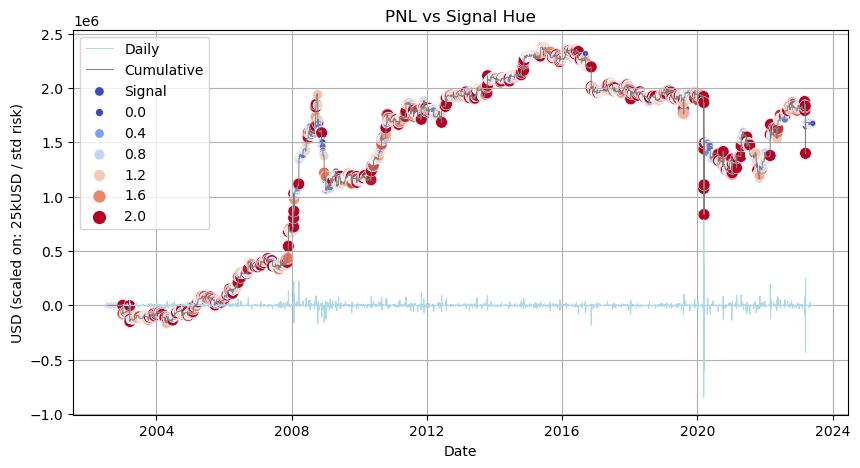

In [7]:
# Grid search optimization for wz1, wz2, wvt parameters for zscore strat
from basic_finance_tools import grid_search

def evaluate_PCA_strat(ts: int, N:int = 1, metric:str='sharpe_ratio') -> float:
    # Strategy evaluation using Z-Score
    global prices

    tickers = prices.columns 
    
    # Create a signal based on the difference of the prices zscore if wz1 != 0, by the difference of the prices if wz1=0
    signal = pd.DataFrame(index=prices.index, columns=tickers)
    signal = compute_signal_PCA(prices, n_principal_component=N, training_size=ts)

    positions = compute_position(signal, prices)

    pnl = compute_PNL(positions, prices)
    return np.abs(compute_metrics(pnl, positions)[metric])

# Define parameter ranges for grid search
param_grid = {
    'ts': np.linspace(10, 150, 10, dtype=int).tolist(),
    'N': [1,2,3],
}

# Print parameter ranges for verification
for key, value in param_grid.items(): print(key, value)

# Perform grid search and print best parameters and result
best_params, best_result = grid_search(evaluate_PCA_strat, param_grid)
print("Best Parameters:", best_params)
print("Best Result:", best_result)
print("\n")

# Visualize strategy using the best parameters
show_strat_PCA(prices, **best_params)

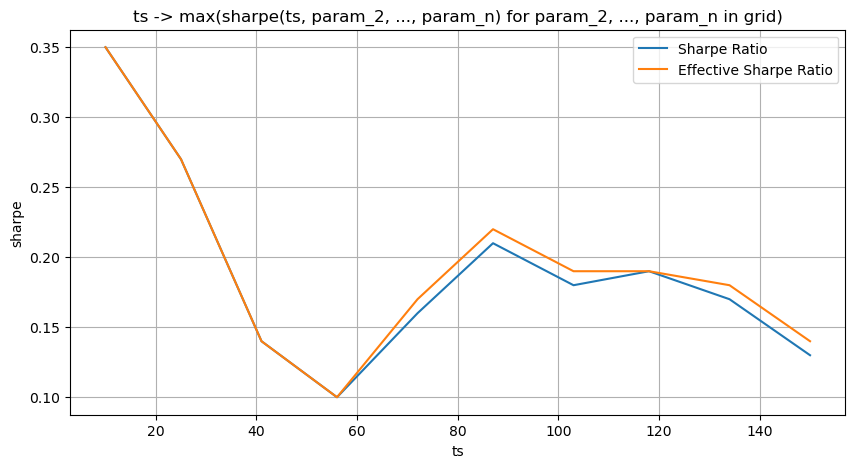

{'sharpe_ratio': 0.2, 'turnover': 127.8, 'bips': 1.5, 'effective_sharpe_ratio': 0.32, 'effective_turnover': 335.5, 'effective_bips': 3.9}


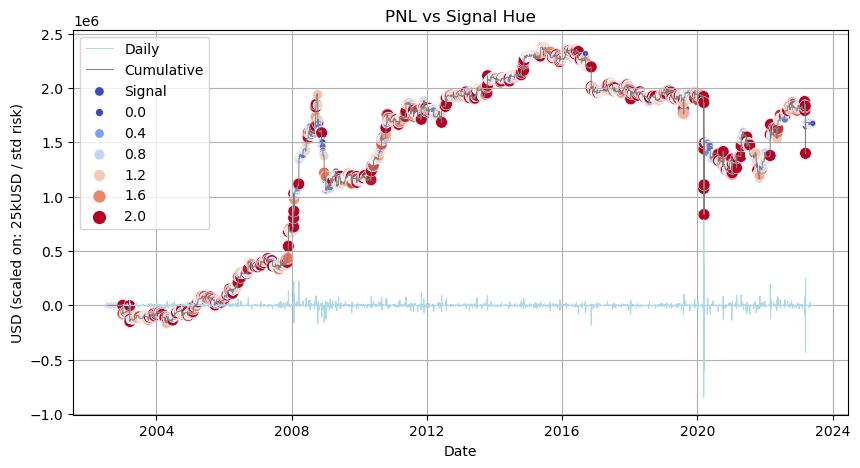

{'sharpe_ratio': 0.26, 'turnover': 126.5, 'bips': 2.2, 'effective_sharpe_ratio': 0.42, 'effective_turnover': 314.1, 'effective_bips': 5.5}


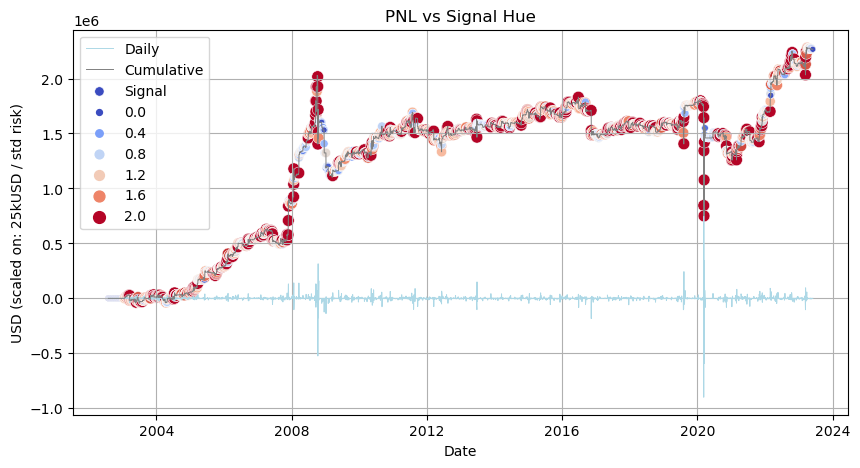

{'sharpe_ratio': 0.08, 'turnover': 122.5, 'bips': 0.7, 'effective_sharpe_ratio': 0.12, 'effective_turnover': 295.7, 'effective_bips': 1.8}


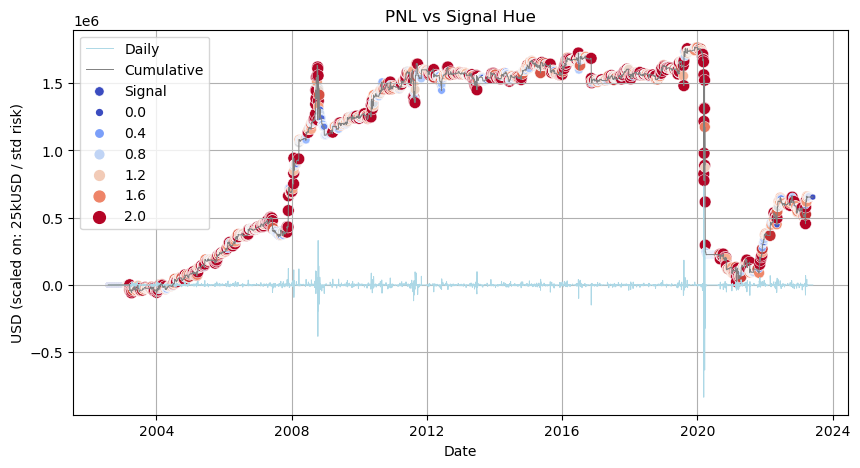

{'sharpe_ratio': 0.04, 'turnover': 121.8, 'bips': 0.4, 'effective_sharpe_ratio': 0.06, 'effective_turnover': 287.4, 'effective_bips': 1.0}


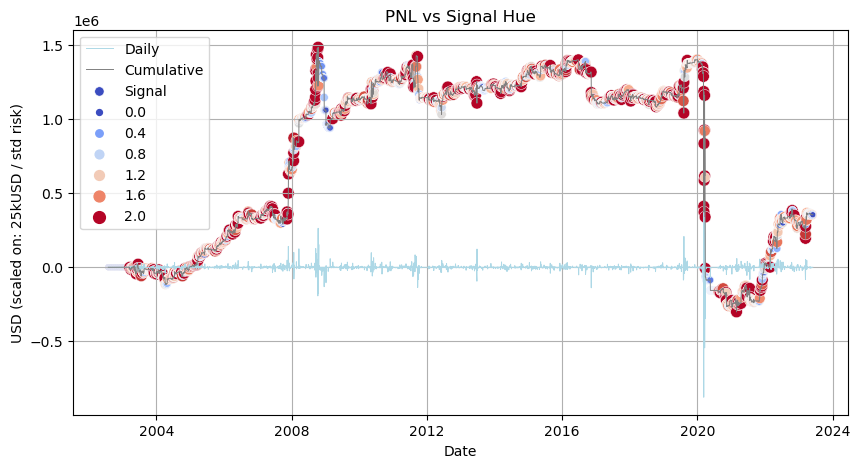

{'sharpe_ratio': 0.16, 'turnover': 121.5, 'bips': 1.5, 'effective_sharpe_ratio': 0.24, 'effective_turnover': 285.7, 'effective_bips': 3.6}


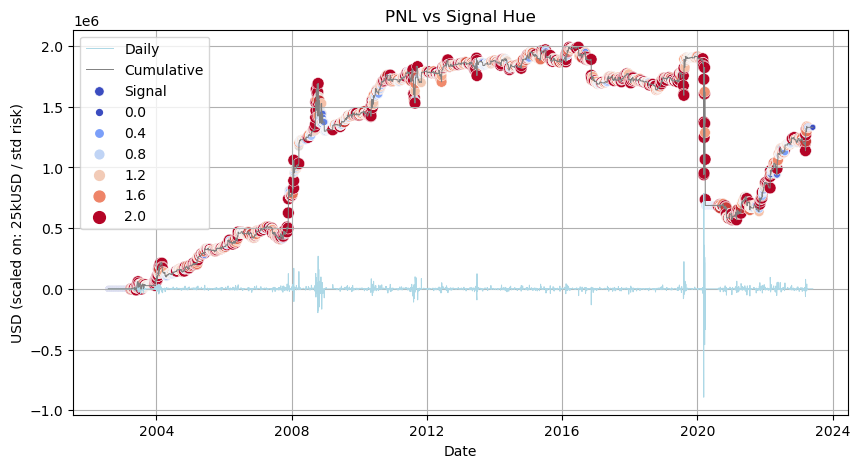

{'sharpe_ratio': 0.18, 'turnover': 121.7, 'bips': 1.6, 'effective_sharpe_ratio': 0.27, 'effective_turnover': 287.8, 'effective_bips': 3.8}


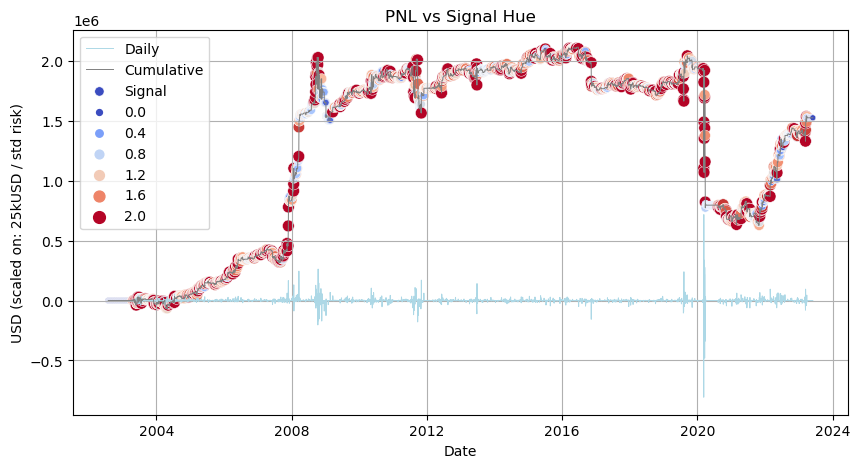

{'sharpe_ratio': 0.11, 'turnover': 124.3, 'bips': 0.9, 'effective_sharpe_ratio': 0.17, 'effective_turnover': 301.5, 'effective_bips': 2.3}


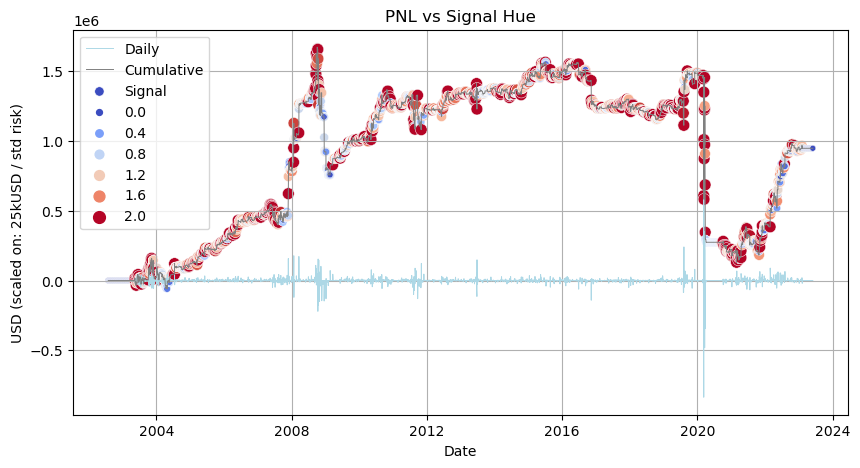

{'sharpe_ratio': 0.14, 'turnover': 123.6, 'bips': 1.4, 'effective_sharpe_ratio': 0.21, 'effective_turnover': 299.8, 'effective_bips': 3.4}


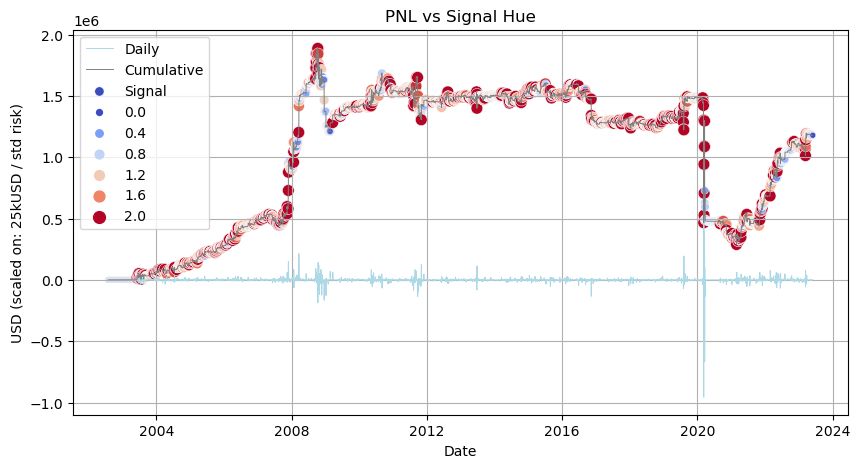

{'sharpe_ratio': 0.12, 'turnover': 123.4, 'bips': 1.1, 'effective_sharpe_ratio': 0.18, 'effective_turnover': 303.3, 'effective_bips': 2.8}


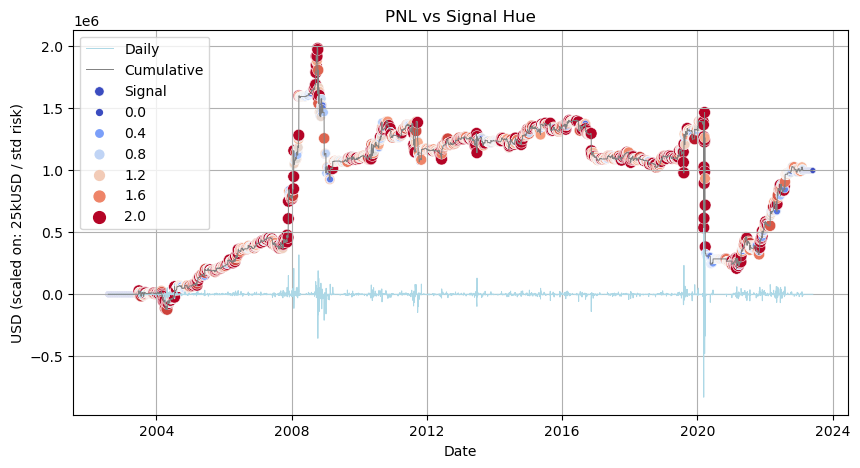

{'sharpe_ratio': 0.08, 'turnover': 122.5, 'bips': 0.9, 'effective_sharpe_ratio': 0.12, 'effective_turnover': 297.9, 'effective_bips': 2.1}


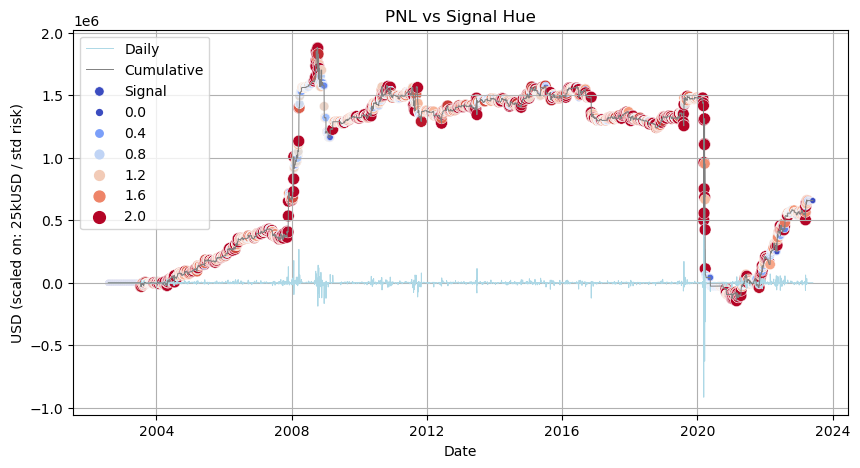

In [8]:
from basic_finance_tools import visualize_param_impact

params_values = visualize_param_impact(evaluate_PCA_strat, param_grid=param_grid, param_selected='ts')
for params in params_values: show_strat_PCA(prices, **params)  
